## HMMs and Viterbi algorithm for POS tagging Assingment

#### BY Mahitha Anumukonda

### Data Preparation

In [1]:
#Importing libraries
import csv
import nltk
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from sklearn.model_selection import train_test_split
from nltk import NgramTagger
from nltk.tokenize import word_tokenize

#### reading the given sample test cases file

In [2]:
filepath="C:\\Users\\HARITHA\\Desktop\\HMM+POS tagger assigement\\"
testFile = open(filepath+"Test_sentences.txt")
testText = testFile.read()
test_sentence= testText.splitlines()
testFile.close()
print(test_sentence)

['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to experience the laun

**Observation**
- We can see that all the proper nouns are beginging with capital letters
- Start of sentence also begins with captial letters
- We have numeric (mostly years) and alpha-numeric data also present

#### reading the Treebank tagged sentences

In [3]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

We do not need the corpus to be segmented into sentences, but can rather use a list of (word, tag) tuples. Let's convert the list into a (word, tag) tuple.

In [5]:
# converting the list of sents to a list of (word, pos tag) tuples
tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

We now have a list of about 100676 (word, tag) tuples. Let's now do some exploratory analyses.

In [6]:
# tokens 
tokens = [pair[0] for pair in tagged_words]
tokens[:10]

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12408


Number of unique words in the nltk data is 12408

In [8]:
# number of tags
T = set([pair[1] for pair in tagged_words])
print("Number of unique tags:"+ str(len(T)))
print("Unique tags:"+ str(T))

Number of unique tags:12
Unique tags:{'ADJ', 'PRON', 'PRT', 'DET', 'ADV', 'VERB', 'NUM', 'NOUN', 'ADP', 'CONJ', '.', 'X'}


### Splitting into train and test

In [9]:
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=1, shuffle=True)
print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('He', 'PRON'), ('has', 'VERB'), ('promised', 'VERB'), ('stiffer', 'ADJ'), ('fines', 'NOUN'), (',', '.'), ('though', 'ADP'), ('the', 'DET'), ('size', 'NOUN'), ('of', 'ADP'), ('penalties', 'NOUN'), ('sought', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('OSHA', 'NOUN'), ('have', 'VERB'), ('been', 'VERB'), ('rising', 'VERB'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('even', 'ADV'), ('before', 'ADP'), ('he', 'PRON'), ('took', 'VERB'), ('office', 'NOUN'), ('this', 'DET'), ('year', 'NOUN'), ('.', '.')], [('At', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('time', 'NOUN'), (',', '.'), ('though', 'ADV'), (',', '.'), ('he', 'PRON'), ('chastised', 'VERB'), ('the', 'DET'), ('media', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('paying', 'VERB'), ('such', 'ADJ'), ('close', 'ADJ'), ('attention', 'NOUN'), ('to', 'PRT'), ('Japanese', 'ADJ'), ('investment', 'NOUN'), ('when', 'ADV'), ('other', 'ADJ'), ('foreign', 'ADJ'), ('countries', 'NOUN'), (',', '.'), ('notably', 'ADV'), ('Britain', 'NOUN'),

In [10]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95668

In [11]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['He',
 'has',
 'promised',
 'stiffer',
 'fines',
 ',',
 'though',
 'the',
 'size',
 'of']

In [12]:
# vocabulary
V = set(tokens)
print(len(V))

12097


There are 12097 unique words in given training data

In [13]:
# number of tags
T = list(set([pair[1] for pair in train_tagged_words]))
T.sort(reverse=True)
print("No.of unique tags in training data:", len(T))
print(T)

No.of unique tags in training data: 12
['X', 'VERB', 'PRT', 'PRON', 'NUM', 'NOUN', 'DET', 'CONJ', 'ADV', 'ADP', 'ADJ', '.']


### Build the vanilla Viterbi based POS tagger

Creating HMM model on the tagged data set:

Calculating Emission Probabaility: P(observation|state)

Calculating Transition Probability: P(state2|state1)

#### Step -1 : Calculating the Emission Probabilities

In [14]:
# computing P(w/t) and storing in T x V matrix
t=len(T)
v=len(V)
w_given_t = np.zeros((t, v))

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Step -2: Transition Probabilities

In [16]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[7.4868858e-02, 2.0394213e-01, 1.8534414e-01, 5.5158161e-02,
        2.7022732e-03, 6.2947065e-02, 5.5317119e-02, 1.0491177e-02,
        2.5433159e-02, 1.4353839e-01, 1.6531553e-02, 1.6372596e-01],
       [2.1680659e-01, 1.6868781e-01, 3.1250000e-02, 3.6069650e-02,
        2.2621268e-02, 1.1108520e-01, 1.3572761e-01, 5.4415422e-03,
        8.1467658e-02, 9.0873756e-02, 6.4598881e-02, 3.5370026e-02],
       [1.4006515e-02, 4.0032575e-01, 1.9543974e-03, 1.8241042e-02,
        5.6026060e-02, 2.4625407e-01, 1.0162866e-01, 2.2801303e-03,
        1.0097720e-02, 1.9543974e-02, 8.5993484e-02, 4.3648209e-02],
       [9.3941718e-02, 4.8082823e-01, 1.3036810e-02, 6.9018407e-03,
        7.2852760e-03, 2.1203987e-01, 9.5858900e-03, 4.9846624e-03,
        3.5276074e-02, 2.3006136e-02, 7.2852761e-02, 4.0260736e-02],
       [2.1434951e-01, 1.6671628e-02, 2.7686812e-02, 1.1908306e-03,
        1.8487646e-01, 3.5040191e-01, 3.2747842e-03, 1.3396844e-02,
        2.9770765e-03, 3.3640966e-02, 3.3343

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [20]:
tags_df

,X,VERB,PRT,PRON,NUM,NOUN,DET,CONJ,ADV,ADP,ADJ,.
X,0.074869,0.203942,0.185344,0.055158,0.002702,0.062947,0.055317,0.010491,0.025433,0.143538,0.016532,0.163726
VERB,0.216807,0.168688,0.031250,0.036070,0.022621,0.111085,0.135728,0.005442,0.081468,0.090874,0.064599,0.035370
PRT,0.014007,0.400326,0.001954,0.018241,0.056026,0.246254,0.101629,0.002280,0.010098,0.019544,0.085993,0.043648
PRON,0.093942,0.480828,0.013037,0.006902,0.007285,0.212040,0.009586,0.004985,0.035276,0.023006,0.072853,0.040261
NUM,0.214350,0.016672,0.027687,0.001191,0.184876,0.350402,0.003275,0.013397,0.002977,0.033641,0.033343,0.118190
NOUN,0.029228,0.146975,0.044224,0.004768,0.009463,0.264286,0.013394,0.042331,0.016743,0.176531,0.012011,0.240045
DET,0.045696,0.038944,0.000241,0.003497,0.022305,0.638896,0.005305,0.000482,0.012539,0.009163,0.204847,0.018085
CONJ,0.008845,0.154562,0.004190,0.059590,0.040503,0.349628,0.120577,0.000466,0.054469,0.049814,0.121974,0.035382
ADV,0.022977,0.346653,0.013986,0.015318,0.031635,0.031635,0.068931,0.006327,0.078921,0.116550,0.128538,0.138528
ADP,0.033837,0.008352,0.001285,0.069172,0.061141,0.324660,0.323803,0.000857,0.013813,0.017025,0.105793,0.040261


In [21]:
tags_df.loc['.', :]

X       0.027703
VERB    0.088757
PRT     0.002062
PRON    0.065806
NUM     0.081764
NOUN    0.222342
DET     0.172136
CONJ    0.058185
ADV     0.052537
ADP     0.092433
ADJ     0.043930
.       0.092254
Name: ., dtype: float32

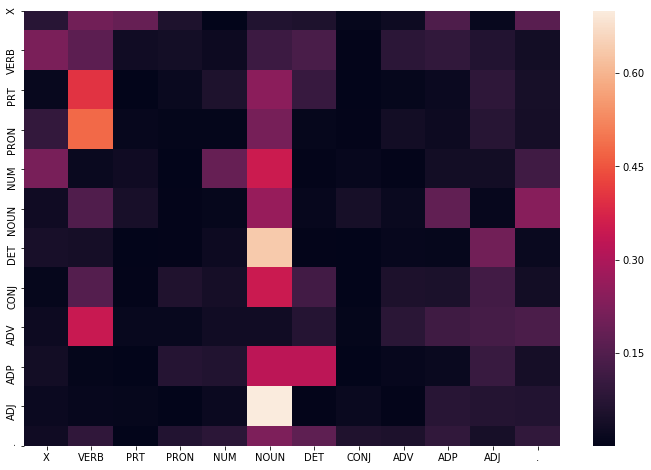

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(12,8))
sns.heatmap(tags_df)
plt.show()

Observation:

The transition probability from ADJ to NOUN is more (>0.7) & DET to NOUN is more than 0.6.

#### Developing algorithm for Viterbi Heuristic

In [23]:
len(train_tagged_words)

95668

As the tag set (T) order is changing everytime we run the code, let us calculate the probability of each tag in the training data and create list of tags with probabilities in increasing order.

In [24]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    T.sort(reverse=True)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Validating Set

In [25]:
# Let's test our Viterbi algorithm on test dataset
# list of untagged words
test_tagged_words=[tup[0] for sent in test_set for tup in sent]
print(len(test_tagged_words))
test_tagged_words

5008


['While',
 'the',
 'new',
 'proposal',
 'might',
 'appeal',
 'to',
 'the',
 'dirtiest',
 'utilities',
 ',',
 'it',
 'might',
 'not',
 'win',
 'the',
 'support',
 'of',
 'utilities',
 ',',
 'many',
 'in',
 'the',
 'West',
 ',',
 'that',
 '*T*-1',
 'already',
 'have',
 'added',
 'expensive',
 'cleanup',
 'equipment',
 'or',
 'burn',
 'cleaner-burning',
 'fuels',
 '.',
 'Mr.',
 'Driscoll',
 'did',
 "n't",
 'elaborate',
 'about',
 'who',
 'the',
 'potential',
 'partners',
 'were',
 '*T*-1',
 'or',
 'when',
 'the',
 'talks',
 'were',
 'held',
 '*-94',
 '*T*-2',
 '.',
 '``',
 'A',
 'lot',
 'of',
 'the',
 'stocks',
 'that',
 '*T*-117',
 'have',
 'been',
 'under',
 'water',
 'finally',
 'saw',
 'a',
 'reason',
 '0',
 '*',
 'to',
 'uptick',
 '*T*-1',
 ',',
 "''",
 'said',
 '*T*-2',
 'George',
 'Jennison',
 ',',
 'head',
 'trader',
 'of',
 'banking',
 'issues',
 'in',
 'Shearson',
 'Lehman',
 'Hutton',
 "'s",
 'OTC',
 'department',
 '.',
 'The',
 'oldest',
 'bell-ringing',
 'group',
 'in',
 'the

We have got total 5008 words for taggig in validation set.Let's run vanilla viterbi algo on this validation set.

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [27]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1779.340321779251
[('While', 'ADP'), ('the', 'DET'), ('new', 'ADJ'), ('proposal', 'NOUN'), ('might', 'VERB'), ('appeal', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('dirtiest', 'ADJ'), ('utilities', 'NOUN'), (',', '.'), ('it', 'PRON'), ('might', 'VERB'), ('not', 'ADV'), ('win', 'VERB'), ('the', 'DET'), ('support', 'NOUN'), ('of', 'ADP'), ('utilities', 'NOUN'), (',', '.'), ('many', 'ADJ'), ('in', 'ADP'), ('the', 'DET'), ('West', 'NOUN'), (',', '.'), ('that', 'DET'), ('*T*-1', 'X'), ('already', 'ADV'), ('have', 'VERB'), ('added', 'VERB'), ('expensive', 'ADJ'), ('cleanup', 'X'), ('equipment', 'NOUN'), ('or', 'CONJ'), ('burn', 'X'), ('cleaner-burning', 'X'), ('fuels', 'X'), ('.', '.'), ('Mr.', 'NOUN'), ('Driscoll', 'NOUN'), ('did', 'VERB'), ("n't", 'ADV'), ('elaborate', 'VERB'), ('about', 'ADP'), ('who', 'PRON'), ('the', 'DET'), ('potential', 'ADJ'), ('partners', 'NOUN'), ('were', 'VERB'), ('*T*-1', 'X'), ('or', 'CONJ'), ('when', 'ADV'), ('the', 'DET'), ('talks', 'NOUN

In [28]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

In [29]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [30]:
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)

0.9091453674121406

In [55]:
print("The accuracy for vanilla viterbi algorithm on training data is ",accuracy_vanilla_viterbi *100)

The accuracy for vanilla viterbi algorithm on training data is  90.91453674121406


Before proceeding for dealing with unknown words, lets first see how many unknown words we have. Unknows words would be
those words that are present in the test set but not in the train set. That is the words the algorithm has not seen before.

In [31]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [53]:
incorrect_tagged_vanilla_viterbi

[[('might', 'VERB'), (('appeal', 'NOUN'), ('appeal', 'VERB'))],
 [('expensive', 'ADJ'), (('cleanup', 'X'), ('cleanup', 'NOUN'))],
 [('or', 'CONJ'), (('burn', 'X'), ('burn', 'VERB'))],
 [('burn', 'VERB'), (('cleaner-burning', 'X'), ('cleaner-burning', 'ADJ'))],
 [('cleaner-burning', 'ADJ'), (('fuels', 'X'), ('fuels', 'NOUN'))],
 [("n't", 'ADV'), (('elaborate', 'VERB'), ('elaborate', 'ADJ'))],
 [('stocks', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('to', 'PRT'), (('uptick', 'NOUN'), ('uptick', 'VERB'))],
 [('George', 'NOUN'), (('Jennison', 'X'), ('Jennison', 'NOUN'))],
 [(',', '.'), (('head', 'NOUN'), ('head', 'ADJ'))],
 [('oldest', 'ADJ'), (('bell-ringing', 'X'), ('bell-ringing', 'ADJ'))],
 [('the', 'DET'), (('Ancient', 'X'), ('Ancient', 'NOUN'))],
 [('College', 'NOUN'), (('Youths', 'X'), ('Youths', 'NOUN'))],
 [('in', 'ADP'), (('1637', 'X'), ('1637', 'NUM'))],
 [('remains', 'VERB'), (('male-only', 'X'), ('male-only', 'ADJ'))],
 [('fact', 'NOUN'), (('that', 'ADP'), ('that', 'DET')

#### Observation:
   
   Most of the words are tagged with 'X'.These might be the unknown words which are tagged to 'X'.The reason is because the tags_df has the first occurence as 'X' and the unknown words are being tagged to 'X'.

### Solve the problem of unknown words

#### Method 1

The default Vanilla viterbi algorithm achieved an accuracy of about 90%. This approx. 10% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'walkout'), it assigned an incorrect tag arbitrarily.
When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [32]:
#To improve the performance,we specify a rule base tagger for unknown words 
# specify patterns for tagging
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [33]:
## modified Viterbi to include rule based tagger in it
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    T.sort(reverse=True)
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))
        

In [34]:
#test accuracy on subset of test data 
start = time.time()
tagged_seq = Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy_rule_based_tagger = len(check)/len(tagged_seq)
print('Viterbi Algorithm with rule-based tagger Accuracy: ',accuracy_rule_based_tagger*100)

Time taken in seconds:  2207.656024456024
Viterbi Algorithm with rule-based tagger Accuracy:  93.41054313099042


Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

### Method 2

In [35]:
# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.931908945686901


In [36]:
# Bigram backed up by the rule-based tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_accuracy=bigram_tagger.evaluate(test_set)
bigram_accuracy

0.9367012779552716

In [37]:
# trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9375


We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 93%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [38]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [39]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [40]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9542731629392971


#### Method 3

This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the vanilla viterbi.

If a word is not present in the training vocabulary (unknown word), its emission probability will be ZERO. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not seen previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below -

If word in unknown then consider only the transition_p (emission probability being 0) else consider both the emission and transition probability.

In [41]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_probabilistic(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [42]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_probabilistic(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

accuracy_viterbi_probabilistic = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", round(accuracy_viterbi_probabilistic*100,4) ,"percent")

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 93.6302 percent


#### Evaluating tagging accuracy

Tagging accuracies for the algorithm on the Validation sentences are:

In [44]:
acccuracy_on_validation_data = [['Vanilla Viterbi', accuracy_vanilla_viterbi*100],
                                 ['Viterbi + probabilistic',accuracy_viterbi_probabilistic*100],
                  ['Rule-based Vanilla Viterbi', accuracy_rule_based_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

validation_data_acccuracy_df = pd.DataFrame(acccuracy_on_validation_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

validation_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

validation_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.914537
Viterbi + probabilistic,93.630192
Rule-based Vanilla Viterbi,93.410543
Viterbi + Trigram_tagger,95.427316


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Tagging accuracies for validation dataset are:

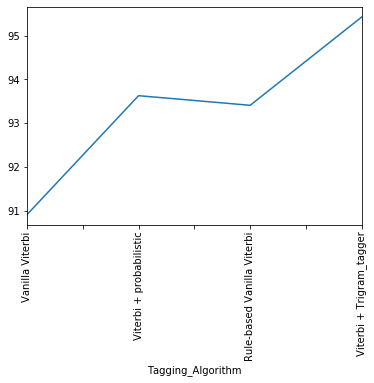

In [45]:
validation_data_acccuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### Case - 1

In [46]:
# test_sentence[0] = 'Android is a mobile operating system developed by Google.'

words_test_sentence_1 = nltk.word_tokenize(test_sentence[0])

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Viterbi(words_test_sentence_1)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)


In [47]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_1 = pd.DataFrame(columns = cols)
tags_correction_df_1 = tags_correction_df_1.fillna(0)

tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, X)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, X)","(Google, NOUN)"
9,"(., .)","(., .)"


#### Observation:
    
    As we see above in sample test sentence 1, Android and Google which were tagged incorrectly as 'X' by vanilla viterbi algo has been tagged correctly as 'Noun' by viterbi with trigram tagger.

### Case - 2

In [48]:
# test_sentence[5] = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, 
#                   an international football tournament contested once every four years.'

words_test_sentence_6 = nltk.word_tokenize(test_sentence[5])

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_6 = Viterbi(words_test_sentence_6)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)

In [49]:
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_6]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_6]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, X)","(2018, NUM)"
2,"(FIFA, X)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, X)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, X)","(21st, NUM)"
8,"(FIFA, X)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


#### Observation:
    
    As we see above in the sample test sentence 6 the following words were incorrectly tagged by the vanilla viterbi algorithm - '2018' - X, 'FIFA' - X, 'Cup' - X, '21st' - X, 'tournament' - X, 'contested' - X.
    The above words were corrected by viterbi backed up by the trigram tagger. The corrections were made as - '2018' - NUM, 'FIFA' - NOUN, 'Cup' - NOUN, '21st' - NUM, 'tournament' - NOUN, 'contested' - VERB.

### Case - 3

In [50]:

# test_sentence[7] = 'Show me the cheapest round trips from Dallas to Atlanta'

words_test_sentence_8 = nltk.word_tokenize(test_sentence[7])

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_8 = Viterbi(words_test_sentence_8)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)


In [51]:
tags_correction_df_8 = pd.DataFrame(columns = cols)
tags_correction_df_8 = tags_correction_df_8.fillna(0)

tags_correction_df_8.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_8]
tags_correction_df_8.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_8]

tags_correction_df_8

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, X)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


As we see in the sample test sentence 8, the vanilla viterbi tagged 'trips' as X. This was corrected by the modified viterbi algorithm (backed up by the trigram tagger) and tagged as NOUN.


Now lets see the tags and corrections for all the sample test sentences with both the methods

In [58]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in test_sentence]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [59]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [60]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

Method 1 - We used only the transition probability for unknown words.

Method 2 - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.

In [62]:

# Default Vanilla Viterbi
# pos tags with Vanilla_Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# Method 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words using transition probability
sample_test_tagged_sequence_unknown_words = Vanilla_Viterbi_probabilistic(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability for unknown words -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('-'*120)

# Method 2 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('us

In [66]:

# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
# 4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, X)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, X)","(Google, NOUN)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, X)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, X)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, X)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, X)","(smartphones, NOUN)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, X)","(2011, NOUN)","(2011, NUM)"
25,"(2013, NUM)","(2013, X)","(2013, NOUN)","(2013, NUM)"
27,"(Google, NOUN)","(Google, X)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, X)","(Twitter, NOUN)","(Twitter, NOUN)"


#### Observation:

The words like Android, Google,2018, 21st,invited which were incorretly tagged as 'X' and other forms by vanilla viterbi and probabilistic viterbi were corrected by viterbi with trigram tagger as Android - 'NOUN',Google - 'NOUN', 2018- 'NUM', 21st- 'NUM', invited -'VERB'.

## Conclusion -

Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.
In this analysis we used 3  modification techniques for the original vanilla viterbi -

Method 1 -
- We used rule based tagger for unknown words.
- The accuracy has increased to 93.4%.

Method 2 -
- We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- This gave us an accuracy of 95.4% on the test data.

Method 3 -
- We used only the transition probability for unknown words.
- This method showed an increase in the accuracy (93.6%) but still had some incorrect classification.
- The accuracy could be increased further and we turned to second modification in method-2 .